## ２値分類（６章）

与えられた点群を２つのグループに分割する。

分割線は、超平面に限らず、曲線である場合もある。

In [83]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import japanize_matplotlib
import torch
from torch import nn

In [84]:
iris = load_iris()

x_org, y_org = iris.data, iris.target

print(x_org.shape, y_org.shape)

(150, 4) (150,)


In [85]:
# 複数の要因だと、理解が困難になるので、最初の２つのみに絞っている
# また、データ数も、最初の１００件のみにしている
x_data = x_org[:100, :2]
y_data = y_org[:100]


In [86]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=70, test_size=30, random_state=123)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(70, 2) (30, 2) (70,) (30,)


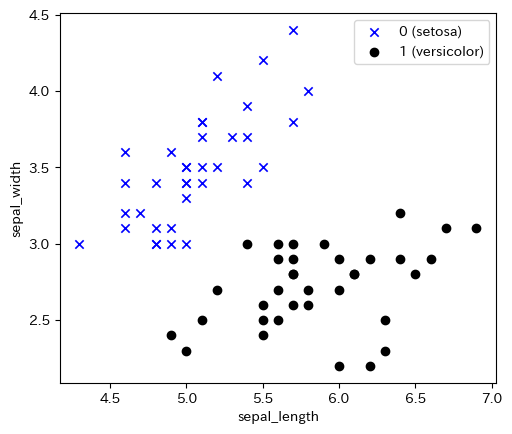

In [101]:
x_t0 = x_train[y_train == 0]
x_t1 = x_train[y_train == 1]
ax = plt.gca()
ax.set_aspect(1)
plt.scatter(x_t0[:, 0], x_t0[:, 1], marker='x', c='b', label='0 (setosa)')
plt.scatter(x_t1[:, 0], x_t1[:, 1], marker='o', c='k', label='1 (versicolor)')
plt.xlabel('sepal_length')
plt.ylabel('sepal_width')
plt.legend()

In [102]:
n_input = x_train.shape[1]
n_output = 1

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_output)
        self.sigmoid = torch.nn.Sigmoid()

        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)
    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.sigmoid(x1)
        return x2

In [103]:
net = Net(n_input, n_output)

print(net)

Net(
  (l1): Linear(in_features=2, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [104]:
from torchinfo import summary

In [105]:
summary(net, (2,))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1]                       --
├─Linear: 1-1                            [1]                       3
├─Sigmoid: 1-2                           [1]                       --
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [106]:
criterion = nn.BCELoss()

from torch import optim

lr = 0.01
optimizer = optim.SGD(net.parameters(), lr=lr)

In [107]:
inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).float()

# 正解データはN行1列の行列として与えるのがPyTorchの仕様
labels1 = labels.view(-1, 1)

inputs_test = torch.tensor(x_test).float()
labels_test = torch.tensor(y_test).float()

labels1_test = labels_test.view(-1, 1)

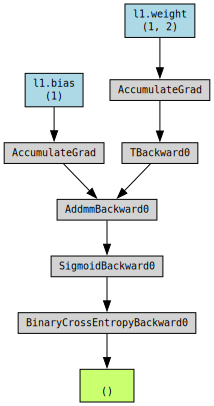

In [108]:
outputs = net(inputs)
loss = criterion(outputs, labels1)

from torchviz import make_dot

g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

In [109]:
num_epochs = 10000

import numpy as np

history = np.zeros((0, 5))

In [110]:
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, labels1)
    loss.backward()
    optimizer.step()
    train_loss = loss.item()
    predicted = torch.where(outputs < 0.5, 0, 1)
    train_acc = (predicted == labels1).sum() / len(y_train)


    outputs_test = net(inputs_test)
    loss_test = criterion(outputs_test, labels1_test)
    val_loss = loss_test.item()
    predicted_test = torch.where(outputs_test < 0.5, 0, 1)
    val_acc = (predicted_test == labels1_test).sum() / len(y_test)
    if epoch % 1000 == 0:
        print(f'Epoch [{epoch}/{num_epochs}, train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}]')
        item = np.array([epoch, train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))


Epoch [0/10000, train_loss: 4.7729, train_acc: 0.5000, val_loss: 4.4938, val_acc: 0.5000]
Epoch [1000/10000, train_loss: 0.3616, train_acc: 1.0000, val_loss: 0.4076, val_acc: 0.9667]
Epoch [2000/10000, train_loss: 0.2368, train_acc: 1.0000, val_loss: 0.2919, val_acc: 0.9667]
Epoch [3000/10000, train_loss: 0.1806, train_acc: 1.0000, val_loss: 0.2404, val_acc: 0.9667]
Epoch [4000/10000, train_loss: 0.1484, train_acc: 1.0000, val_loss: 0.2116, val_acc: 0.9667]
Epoch [5000/10000, train_loss: 0.1274, train_acc: 1.0000, val_loss: 0.1932, val_acc: 0.9667]
Epoch [6000/10000, train_loss: 0.1124, train_acc: 1.0000, val_loss: 0.1804, val_acc: 0.9667]
Epoch [7000/10000, train_loss: 0.1012, train_acc: 1.0000, val_loss: 0.1711, val_acc: 0.9667]
Epoch [8000/10000, train_loss: 0.0924, train_acc: 1.0000, val_loss: 0.1640, val_acc: 0.9667]
Epoch [9000/10000, train_loss: 0.0853, train_acc: 1.0000, val_loss: 0.1584, val_acc: 0.9667]


In [111]:
print(f'[初期状態] 損失: {history[0, 3]:.5f}, 精度: {history[0, 4]:.5f}')
print(f'[最終状態] 損失: {history[-1, 3]:.5f}, 精度: {history[-1, 4]:.5f}')

[初期状態] 損失: 4.49384, 精度: 0.50000
[最終状態] 損失: 0.15839, 精度: 0.96667


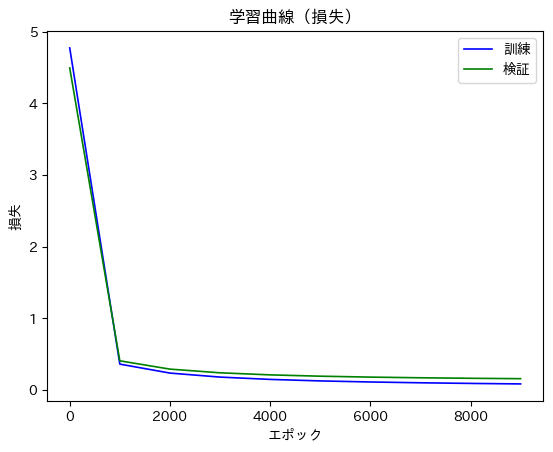

In [112]:
plt.plot(history[:, 0], history[:, 1], c='b', label='訓練')
plt.plot(history[:, 0], history[:, 3], c='g', label='検証')
plt.xlabel('エポック')
plt.ylabel('損失')
plt.title('学習曲線（損失）')
plt.legend()

In [113]:
# パラメータの取得

bias = net.l1.bias.data.numpy()
weight = net.l1.weight.data.numpy()
print(f'BIAS = {bias}, WEIGHT = {weight}')

# 決定境界描画用 x1の値から x2の値を計算する
def decision(x):
    return(-(bias + weight[0,0] * x)/ weight[0,1])

# 散布図のx1の最小値と最大値
xl = np.array([x_test[:,0].min(), x_test[:,0].max()])
yl = decision(xl)

# 結果確認
print(f'xl = {xl}  yl = {yl}')

BIAS = [0.33861226], WEIGHT = [[ 2.9700334 -5.300017 ]]
xl = [4.4 7. ]  yl = [2.52956916 3.98656204]


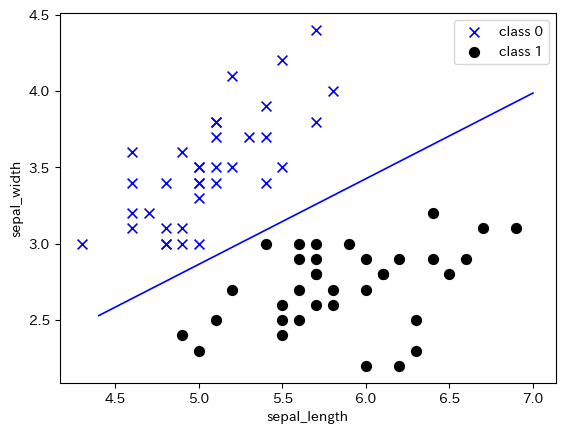

In [114]:
# 散布図表示
plt.scatter(x_t0[:,0], x_t0[:,1], marker='x', 
        c='b', s=50, label='class 0')
plt.scatter(x_t1[:,0], x_t1[:,1], marker='o', 
        c='k', s=50, label='class 1')

# 決定境界直線
plt.plot(xl, yl, c='b')
plt.xlabel('sepal_length')
plt.ylabel('sepal_width')
plt.legend()
plt.show()